# Coding Assignment "Bonus #2"

## 1. Preparation

### 1.1. Libraries

In [27]:
# Modules.
import torch
import colorsys
import numpy as np 
import pandas as pd 
import networkx as nx 

# Submodules
import torch.nn as nn
import torch.nn.functional as F
from numpy import linalg as LA
import matplotlib.pyplot as plt 

# Methods
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### 1.2. Helper functions

In [28]:
# The function generates returns the numpy array
# of num_colors distinctive colors in RGB format.
def generate_distinctive_colors(num_colors):
    colors = []
    hue_step = 1.0 / num_colors
    saturation = 0.7
    value = 0.9
    for i in range(num_colors):
        hue = i * hue_step
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return np.array(colors)

# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    # Get the number of clusters.
    num_clusters = len(set([G_FMI.nodes[node]['cluster'] for node in G_FMI.nodes]))
    
    # Get the colors for clusters.
    colors = generate_distinctive_colors(num_clusters)
    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        color = colors[G_FMI.nodes[node]['cluster']]
        plt.scatter(coords[node,1], coords[node,0], color=color, s=4, zorder=5)  # zorder ensures nodes are on top of edges
        plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color=color, fontweight='bold')
    
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    n_features = 7 
    n_datapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of a data point) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((n_datapoints, n_features))
    y = np.zeros((n_datapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label. 
    for i in range(n_datapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[i])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[i])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[i]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[i], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[i,:] = [lat, lon, year, month, day, hour, minute]
        y[i,:] = tmp

    return X, y

def add_edges(graph_FMI, num_neighbors):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    for node in graph.nodes:
        
        # Representation vector of the node.
        z_node = graph.nodes[node]['z']
        
        # Create storages for discrepancies and the corresponding neighbors.
        d_mins = np.full(shape=num_neighbors, fill_value=1e10)
        edges = np.full(shape=(num_neighbors, 2), fill_value=(node, -1))
        
        # Iterate over nodes to find the neighbors. 
        for potential_neighbor in graph.nodes:
            if potential_neighbor != node:
                # Representation vector of the potential neighbor.
                z_neighbor = graph.nodes[potential_neighbor]['z']
                d = LA.norm(z_node - z_neighbor)

                # Find the max discrepancy so far.
                d_max_idx = np.argmax(d_mins)
                d_max = d_mins[d_max_idx]
                
                # Check if the new discrepancy is less than 
                # the current maximum one.
                if d < d_max:
                    d_mins[d_max_idx] = d
                    edges[d_max_idx][1] = potential_neighbor

        graph.add_edges_from(edges) 

    return graph

def add_edges_gradient_loss(graph_FMI, num_neighbors, X, y):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Define and fit the Linear regression.
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)

    # Extract the weight vector.
    w_hat = linear_reg.coef_

    # Calculate the average squared error loss.
    for node in graph.nodes:
        node_X = graph.nodes[node]['X']
        node_y = graph.nodes[node]['y']
        m = graph.nodes[node]['samplesize']
        loss = (-2/m) * node_X.T.dot(node_y - node_X.dot(w_hat.T))
        graph.nodes[node]['z'] = loss

    # Add edges.
    graph = add_edges(graph, num_neighbors)
    
    return graph

## 2. Data

### 2.1. Dataset

In [29]:
# Import the weather measurements.
data_FMI = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
n_stations = len(data_FMI.name.unique())
n_datapoints = len(data_FMI)

### 2.2. Features and labels

In [30]:
# Extract features and labels from the FMI data.
X_global, y_global = ExtractFeatureMatrixLabelVector(data_FMI)

print(f"The created feature matrix contains {np.shape(X_global)[0]} entries of {np.shape(X_global)[1]} features each.")
print(f"The created label vector contains {np.shape(y_global)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


### 2.3. Empirical graph

The graph is connected: True


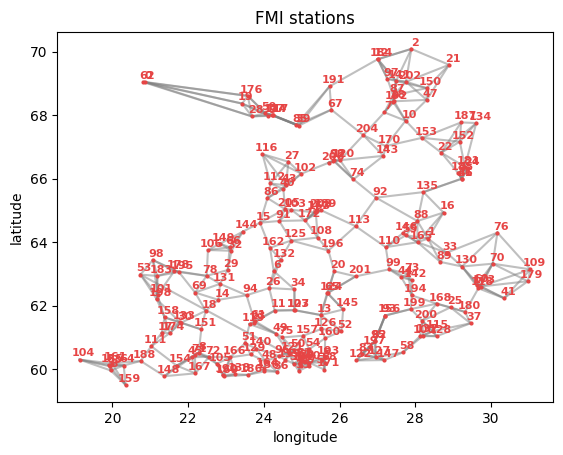

In [31]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data_FMI.name.unique()):
    # Extract data of a certain station
    station_data = data_FMI[data_FMI.name==station]
    
    # Extract features and labels of a certain station.
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    # Split the dataset into training and validation set. 
    X_train, X_val, y_train, y_val = train_test_split(X_node, y_node, test_size=0.2, random_state=4740)
    
    # Store the station's data in the node's attributes. 
    G_FMI.nodes[i]['samplesize'] = len(y_node) # The number of measurements of the i-th weather station.
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station.
    G_FMI.nodes[i]['coord'] = np.array([station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]]) # The coordinates of the i-th weather station.
    G_FMI.nodes[i]['X'] = X_node # The feature matrix for local dataset at node i.
    G_FMI.nodes[i]['y'] = y_node  # The  label vector for local dataset at node i.
    G_FMI.nodes[i]['X_train'] = X_train # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['z'] = None # The representation vector for local dataset at node i.
    G_FMI.nodes[i]['cluster'] = 0 # The cluster to which the node is assigned (default value = 0).
    G_FMI.nodes[i]['model'] = None
    G_FMI.nodes[i]['updated_params'] = None

# Construct edges based on the similar gradient of the loss. 
G_FMI_with_edges = add_edges_gradient_loss(G_FMI, 4, X_global, y_global)

# Visualize the empirical graph.
print(f"The graph is connected: {nx.is_connected(G_FMI_with_edges)}")
plotFMI(G_FMI_with_edges)

## 3. Model

### 3.1. Student task - Neural network structure

In [32]:
####################TODO####################
# TODO: Construct a neural network.
#
# NOTE: PyTorch tutorials: https://pytorch.org/tutorials/
#
# Grading: 11 points for the average validation error <= 25,
#          5.5 points for the average validation error <= 30,
#          0 points for the average validation error > 30 .

class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(7, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [33]:
# Initialize the model in each node
for node in G_FMI_with_edges.nodes:
    G_FMI_with_edges.nodes[node]['model'] = NeuralNetwork()

### 3.2. FedGD with Neural Networks

In [34]:
# Define hyperparameters
alpha = 0.5
l_rate = 0.001

# Define initial values and storage
prev_loss_avg = 1e10
curr_loss_avg = 1e9
tol = 0.01
n_iterations = 0

# Iterate while the average loss over all nodes is decreasing
while curr_loss_avg < prev_loss_avg:
    
    n_iterations += 1
    losses = np.zeros(n_stations)
    
    # Iterate over all nodes
    for current_node in G_FMI_with_edges.nodes:
        model = G_FMI_with_edges.nodes[current_node]['model']
        
        # Get training data.
        X_train = torch.tensor(G_FMI_with_edges.nodes[current_node]['X_train'], dtype=torch.float32)
        y_train = torch.tensor(G_FMI_with_edges.nodes[current_node]['y_train'], dtype=torch.float32)

        # Forward pass
        outputs = model(X_train)
        loss = torch.nn.functional.mse_loss(outputs, y_train)
        losses[current_node] = loss.item()
        
        # Compute the gradients
        loss.backward()

        # Gather parameters and send to neighbors
        with torch.no_grad():
            # Get the local parameters
            local_params = [param.data for param in model.parameters()]
            
            # Get the gradient of the local loss.
            term_1 = [param.grad for param in model.parameters()]
            
            term_2 = 0
            neighbors = list(G_FMI_with_edges.neighbors(current_node))
            for neighbor in neighbors:
                neighbor_params = [param.data for param in G_FMI_with_edges.nodes[neighbor]['model'].parameters()]
                
                params_diff = [neighbor - local for neighbor, local in zip(neighbor_params, local_params)]
                if term_2 == 0:
                    term_2 = params_diff
                else:
                    term_2 = [a + b for a, b in zip(term_2, params_diff)]

            term_2 = [a * 2 * alpha for a in term_2]
            
            # Equation 5.9
            G_FMI_with_edges.nodes[current_node]['updated_params'] = [local - l_rate * (t_1 + t_2) for local, t_1, t_2 in zip(local_params, term_1, term_2)]

    for node in G_FMI_with_edges.nodes:
        model_node = G_FMI_with_edges.nodes[node]['model']
        for i, param in enumerate(model_node.parameters()):
            param.data = nn.parameter.Parameter(G_FMI_with_edges.nodes[node]['updated_params'][i])
            param.grad = None
    
    prev_loss_avg = curr_loss_avg
    curr_loss_avg = np.mean(losses)
    print(f"Iteration: {n_iterations}, average loss: {curr_loss_avg}")
    
print(f"{n_iterations} iterations have been performed. The average loss is {prev_loss_avg}")

Iteration: 1, average loss: 173.06306979736843
Iteration: 2, average loss: 163.82698678970337
Iteration: 3, average loss: 154.4400078455607
Iteration: 4, average loss: 143.7092098084049
Iteration: 5, average loss: 130.82527199344358
Iteration: 6, average loss: 115.5736680376357
Iteration: 7, average loss: 98.73566718723463
Iteration: 8, average loss: 82.16331117279863
Iteration: 9, average loss: 67.96821828740806
Iteration: 10, average loss: 57.30711511022227
Iteration: 11, average loss: 50.05849044680019
Iteration: 12, average loss: 45.44537283487366
Iteration: 13, average loss: 42.620585029251906
Iteration: 14, average loss: 40.90495952200774
Iteration: 15, average loss: 39.83836685401806
Iteration: 16, average loss: 39.1430521932777
Iteration: 17, average loss: 38.661329280926985
Iteration: 18, average loss: 38.30448927395586
Iteration: 19, average loss: 38.02148968470845
Iteration: 20, average loss: 37.78221884557014
Iteration: 21, average loss: 37.568518532647026
Iteration: 22, av

### 3.3. Train and validation errors

In [35]:
train_error_avg = 0
val_error_avg = 0

for node in G_FMI_with_edges.nodes:
    # Calculate training error.
    X_train = torch.tensor(G_FMI_with_edges.nodes[node]['X_train'], dtype=torch.float32)
    y_train = G_FMI_with_edges.nodes[node]['y_train']
    y_train_pred = G_FMI_with_edges.nodes[node]['model'](X_train).detach().numpy()
    train_error_avg += mean_squared_error(y_train, y_train_pred)
    
    # Calculate validation error.
    X_val = torch.tensor(G_FMI_with_edges.nodes[node]['X_val'], dtype=torch.float32)
    y_val = G_FMI_with_edges.nodes[node]['y_val']
    y_val_pred = G_FMI_with_edges.nodes[node]['model'](X_val).detach().numpy()
    val_error_avg += mean_squared_error(y_val, y_val_pred)

train_error_avg /= n_stations
val_error_avg /= n_stations

print(f"The average training error is {train_error_avg}")
print(f"The average validation error is {val_error_avg}")

The average training error is 23.11332067709698
The average validation error is 24.63685836516444


## 4. Grading

In [36]:
if val_error_avg <= 25:
    n_points = 11
elif val_error_avg <= 30:
    n_points = 5.5
else:
    n_points = 0
    
print(f"You will recive {n_points} points for this assignment.")

You will recive 11 points for this assignment.
